# Introduction to the xgbsurv package - Breslow

This notebook introduces `xgbsurv` using a specific dataset. It structured by the following steps:

- Load data
- Load model
- Fit model
- Predict and evaluate model

The syntax conveniently follows that of sklearn.

In [1]:
from xgbsurv.datasets import load_metabric
from xgbsurv import XGBSurv
from xgbsurv.models.utils import sort_X_y, transform_back
from pycox.evaluation import EvalSurv
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
current_path = os.getcwd() 
one_level_up = os.path.abspath(os.path.join(current_path,  ".."))

## Load Data

In [2]:
data = load_metabric(path=one_level_up+"/xgbsurv/datasets/data/", as_frame=False)
# stratify by event indicated by sign
target_sign = np.sign(data.target)
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, stratify=target_sign)
# sort data
X_train, y_train = sort_X_y(X_train, y_train)
X_test, y_test = sort_X_y(X_test, y_test)

Values are being sorted!
Values are being sorted!


## Load Model

In [3]:
model = XGBSurv(n_estimators=100, objective="efron_objective",
                                             eval_metric="efron_loss",
                                             learning_rate=0.3,
                                             random_state=42, 
                                             disable_default_eval_metric=1,
                                             )
model

XGBSurv(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
        colsample_bynode=None, colsample_bytree=None,
        disable_default_eval_metric=1, early_stopping_rounds=None,
        enable_categorical=False,
        eval_metric=CPUDispatcher(<function efron_likelihood at 0x176fd5b20>),
        feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
        importance_type=None, interaction_constraints=None, learning_rate=0.3,
        max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
        max_delta_step=None, max_depth=None, max_leaves=None,
        min_child_weight=None, missing=nan, monotone_constraints=None,
        n_estimators=100, n_jobs=None, num_parallel_tree=None,
        objective=CPUDispatcher(<function efron_objective at 0x176fd62a0>), ...)

The options of loss and objective functions can be obtained like below:

In [4]:
print(model.get_loss_functions().keys())
print(model.get_objective_functions().keys())

dict_keys(['breslow_loss', 'efron_loss', 'cind_loss', 'deephit_loss', 'aft_loss', 'ah_loss', 'eh_loss'])
dict_keys(['breslow_objective', 'efron_objective', 'cind_objective', 'deephit_objective', 'aft_objective', 'ah_objective', 'eh_objective'])


## Fit Model

In [5]:
eval_set = [(X_train, y_train)]

In [6]:
model.fit(X_train, y_train, eval_set=eval_set)

[0]	validation_0-efron_likelihood:6.39347
[1]	validation_0-efron_likelihood:6.30436
[2]	validation_0-efron_likelihood:6.22972
[3]	validation_0-efron_likelihood:6.18297
[4]	validation_0-efron_likelihood:6.13534
[5]	validation_0-efron_likelihood:6.08632
[6]	validation_0-efron_likelihood:6.04115
[7]	validation_0-efron_likelihood:6.00533
[8]	validation_0-efron_likelihood:5.96784
[9]	validation_0-efron_likelihood:5.94879
[10]	validation_0-efron_likelihood:5.91296
[11]	validation_0-efron_likelihood:5.89878
[12]	validation_0-efron_likelihood:5.86356
[13]	validation_0-efron_likelihood:5.85809
[14]	validation_0-efron_likelihood:5.83768
[15]	validation_0-efron_likelihood:5.81157
[16]	validation_0-efron_likelihood:5.80369
[17]	validation_0-efron_likelihood:5.79303
[18]	validation_0-efron_likelihood:5.78031
[19]	validation_0-efron_likelihood:5.76830
[20]	validation_0-efron_likelihood:5.75873
[21]	validation_0-efron_likelihood:5.75333
[22]	validation_0-efron_likelihood:5.73390
[23]	validation_0-efr

XGBSurv(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
        colsample_bynode=None, colsample_bytree=None,
        disable_default_eval_metric=1, early_stopping_rounds=None,
        enable_categorical=False,
        eval_metric=CPUDispatcher(<function efron_likelihood at 0x176fd5b20>),
        feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
        importance_type=None, interaction_constraints=None, learning_rate=0.3,
        max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
        max_delta_step=None, max_depth=None, max_leaves=None,
        min_child_weight=None, missing=nan, monotone_constraints=None,
        n_estimators=100, n_jobs=None, num_parallel_tree=None,
        objective=CPUDispatcher(<function efron_objective at 0x176fd62a0>), ...)

The model can be saved like below. Note that objective and eval_metric are not saved.

In [7]:
#model.save_model("introduction_model_breslow.json")

## Predict

In [8]:
preds_train = model.predict(X_train, output_margin=True)
preds_test = model.predict(X_test, output_margin=True)

### Predict Cumulative Hazard

In [9]:
df_cum_hazards = model.predict_cumulative_hazard_function(X_train, X_test, y_train, y_test)
df_cum_hazards.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,466,467,468,469,470,471,472,473,474,475
297.233337,13.937462,13.990066,8.041028,6.432954,18.476347,0.921052,2.107142,16.889346,43.431215,7.726851,...,0.361727,2.918032,5.642390,36.672990,5.284059,4.124300,3.045750,3.480728,3.415407,123.153840
297.799988,13.937462,13.990066,8.041028,6.432954,18.476347,0.921052,2.107142,16.889346,43.431215,7.726851,...,0.361727,2.918032,5.642390,36.672990,5.284059,4.124300,3.045750,3.480728,3.415407,123.153840
300.866669,17.855330,17.922721,10.301389,8.241280,23.670111,1.179963,2.699467,21.637000,55.639879,9.898895,...,0.463410,3.738301,7.228485,46.981894,6.769426,5.283654,3.901921,4.459172,4.375489,157.772807


## Predict Survival Function

In [10]:
df_survival_function = model.predict_survival_function(X_train, X_test, y_train, y_test)
df_survival_function.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,466,467,468,469,470,471,472,473,474,475
297.233337,8.851913e-07,8.398304e-07,0.000322,0.001608,9.458549e-09,0.39810,0.121585,4.624343e-08,1.374241e-19,0.000441,...,0.696472,0.054040,0.003544,1.183376e-16,0.005072,0.016175,0.047561,0.030785,0.032863,3.273156e-54
297.799988,8.851913e-07,8.398304e-07,0.000322,0.001608,9.458549e-09,0.39810,0.121585,4.624343e-08,1.374241e-19,0.000441,...,0.696472,0.054040,0.003544,1.183376e-16,0.005072,0.016175,0.047561,0.030785,0.032863,3.273156e-54
300.866669,1.760064e-08,1.645360e-08,0.000034,0.000264,5.250507e-11,0.30729,0.067241,4.010241e-10,6.853427e-25,0.000050,...,0.629135,0.023794,0.000726,3.944780e-21,0.001148,0.005074,0.020203,0.011572,0.012582,3.020928e-69


### Visualize Predictions

Text(0.5, 1.0, 'Cumulative Hazard Breslow')

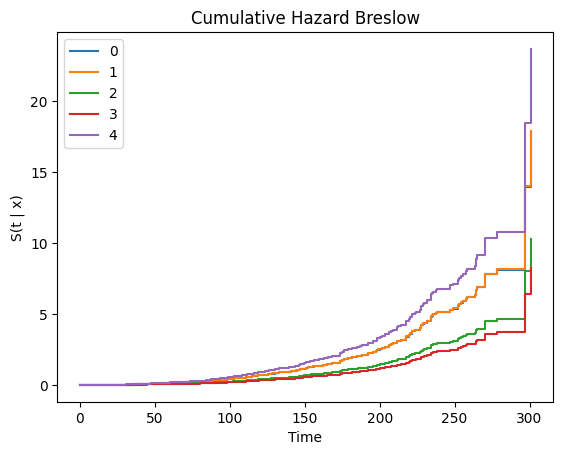

In [11]:
df_cum_hazards.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
plt.title("Cumulative Hazard Breslow")

Text(0.5, 1.0, 'Survival Curve Breslow')

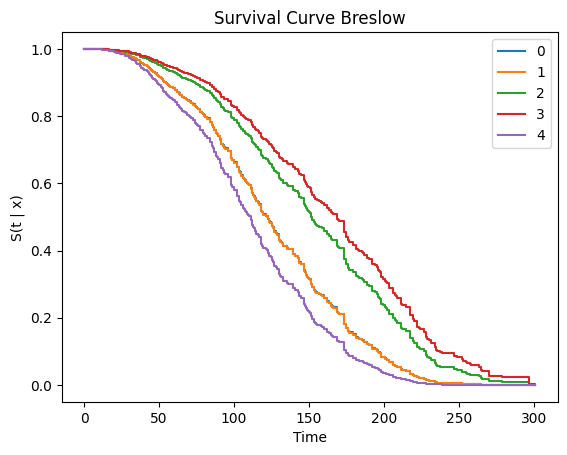

In [12]:
df_survival_function.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
plt.title("Survival Curve Breslow")

## Evaluate

### Test

In [13]:
durations_test, events_test = transform_back(y_test)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(df_survival_function, durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))

Concordance Index 0.6165476205742424


In [14]:
print('Integrated Brier Score:',ev.integrated_brier_score(time_grid))

Integrated Brier Score: 0.20464930130446557
